In [1023]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

#### Dataset and input formatting

In [1024]:
# read in all the words
words = open('makemore_dataset/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [1025]:
len(words)

32033

In [1026]:
# map each character to an index for one-hot encoding
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

In [1027]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [1028]:
x, y = [], []


for w in words[:3]:
    for c1, c2 in zip(w, w[1:]):
        i1, i2 = stoi[c1], stoi[c2]
        x.append(i1)
        y.append(i2)

xs = torch.tensor(x)
num = xs.nelement()
ys = torch.tensor(y)

In [1029]:
xs, ys

(tensor([ 5, 13, 13, 15, 12,  9, 22,  9,  1, 22]),
 tensor([13, 13,  1, 12,  9, 22,  9,  1, 22,  1]))

In [1030]:
# initialise the neural network weights
g = torch.Generator().manual_seed(11)
W = torch.rand((27, 27), requires_grad=True, generator=g)

#### Training loop

In [1800]:
# inputs are reinstatiated for each loop through the training data
inputs = F.one_hot(xs, num_classes=27).float()

In [1801]:
logits = (inputs @ W)
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs

tensor([[0.0146, 0.0162, 0.0159, 0.0123, 0.0122, 0.0172, 0.0234, 0.0269, 0.0187,
         0.0129, 0.0153, 0.0192, 0.0195, 0.5326, 0.0148, 0.0194, 0.0256, 0.0129,
         0.0155, 0.0134, 0.0146, 0.0260, 0.0214, 0.0171, 0.0173, 0.0250, 0.0202],
        [0.0118, 0.2963, 0.0145, 0.0119, 0.0194, 0.0155, 0.0126, 0.0202, 0.0138,
         0.0103, 0.0141, 0.0181, 0.0129, 0.3299, 0.0130, 0.0131, 0.0190, 0.0147,
         0.0193, 0.0190, 0.0180, 0.0100, 0.0108, 0.0107, 0.0182, 0.0149, 0.0180],
        [0.0118, 0.2963, 0.0145, 0.0119, 0.0194, 0.0155, 0.0126, 0.0202, 0.0138,
         0.0103, 0.0141, 0.0181, 0.0129, 0.3299, 0.0130, 0.0131, 0.0190, 0.0147,
         0.0193, 0.0190, 0.0180, 0.0100, 0.0108, 0.0107, 0.0182, 0.0149, 0.0180],
        [0.0156, 0.0173, 0.0208, 0.0184, 0.0138, 0.0177, 0.0139, 0.0120, 0.0199,
         0.0257, 0.0252, 0.0178, 0.5414, 0.0123, 0.0177, 0.0112, 0.0120, 0.0228,
         0.0235, 0.0120, 0.0240, 0.0228, 0.0144, 0.0222, 0.0209, 0.0125, 0.0122],
        [0.0159, 0.0222,

In [1802]:
# prob for each index = 1
xs

tensor([ 5, 13, 13, 15, 12,  9, 22,  9,  1, 22])

In [1803]:
# prob for eeach index = 1
ys

tensor([13, 13,  1, 12,  9, 22,  9,  1, 22,  1])

In [1804]:
# probabilities for indexes given by ys, should approach 1
probs[torch.arange(num), ys]

tensor([0.5326, 0.3299, 0.2963, 0.5414, 0.4618, 0.2808, 0.3182, 0.3058, 0.4875,
        0.3260], grad_fn=<IndexBackward0>)

In [1805]:
# characterize error with nll
loss = -probs[torch.arange(num), ys].log().mean()
loss

tensor(0.9781, grad_fn=<NegBackward0>)

In [1806]:
# backprop
W.grad = None
loss.backward()

In [1807]:
loss

tensor(0.9781, grad_fn=<NegBackward0>)

In [1808]:
W.data += -0.5 * W.grad

#### Sampling from the network

Each column of the weights matrix denotes outgoing weights from an input neuron, and can be interpreted as a probability distribution

In [1817]:
g = torch.Generator().manual_seed(11)
names = []
# sample ten words, starting at the 0-character each time
for i in range(5):
    # sample until stopping character is outputted
    ix = 0
    s = ''
    while True:
        char = itos[ix]
        s += char

        input = F.one_hot(torch.tensor(ix), num_classes=27).float()
        logits = input @ W
        counts = logits.exp()
        probs = counts / counts.sum(0, keepdim=True)

        ix = torch.multinomial(probs, generator=g, replacement=True, num_samples=1).item()

        if ix == 0:
            break
    
    names.append(s)

names

['.emkiapmzhsavtjxggiavicogbwvivavnflitcwsuxbpgxbnuxblipbslyy',
 '.bviyegyxzzdytpdf',
 '.lliazosctztrlivdhsx',
 '.nxemjbrjhgtnzva',
 '.vwjemdviammmmruiaxwjmahyemmdykmkoliavavaiaydoluemmijjdfrevivassxwevohndunusulivwiavoruywoluolemlivgyuarrjiavjwfztbzttkiavavusprgbskhem']

In [1818]:
probs

tensor([0.0116, 0.2991, 0.0143, 0.0117, 0.0191, 0.0153, 0.0124, 0.0199, 0.0136,
        0.0102, 0.0140, 0.0178, 0.0128, 0.3319, 0.0129, 0.0129, 0.0188, 0.0146,
        0.0191, 0.0188, 0.0177, 0.0099, 0.0107, 0.0106, 0.0180, 0.0147, 0.0178],
       grad_fn=<DivBackward0>)

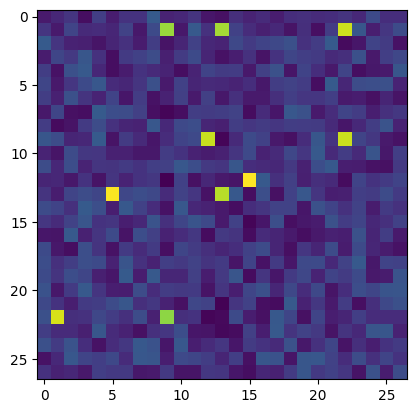

In [1823]:
weights = W
weights = weights.detach().numpy()
plt.imshow(weights.T)